In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample
import re
# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Bert model and tokenizer
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
# for handling data loading and batching.
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

'''
# Import packages for data modeling
import sagemaker
import sys
import boto3
from time import gmtime, strftime
from pathlib import Path

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sess = boto3.Session()
sm = sess.client('sagemaker')
'''


"\n# Import packages for data modeling\nimport sagemaker\nimport sys\nimport boto3\nfrom time import gmtime, strftime\nfrom pathlib import Path\n\nsagemaker_session = sagemaker.Session()\nrole = sagemaker.get_execution_role()\nregion = boto3.Session().region_name\nsess = boto3.Session()\nsm = sess.client('sagemaker')\n"

In [ ]:
# cell used previously in aws sagemaker but had to transition back to colab to reduce costs
'''
s3 = boto3.resource('s3')
for buckets in s3.buckets.all():
    if 'aws1sentiment' in buckets.name:
        bucket = buckets.name
print("Bucket: ", bucket)
prefix = 'data'
output_path = 's3://{}/{}/output'.format(bucket, prefix)

# Configure the training paths
train_path = f"s3://{bucket}/{prefix}/twitter_training.csv"
validation_path = f"s3://{bucket}/{prefix}/twitter_validation.csv"
print(train_path)
print(validation_path)
print('s3://aws1sentiment/data/twitter_training.csv')'''



Bucket:  aws1sentiment
s3://aws1sentiment/data/twitter_training.csv
s3://aws1sentiment/data/twitter_validation.csv
s3://aws1sentiment/data/twitter_training.csv


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_train = pd.read_csv('/content/drive/MyDrive/KaggleDatasets/twitter_training.csv', header= None)
data_val = pd.read_csv('/content/drive/MyDrive/KaggleDatasets/twitter_validation.csv', header= None)
data_train = data_train.rename(columns = {0: 'tweetID', 1:'entity', 2:'sentiment', 3:'tweet_text'})
data_val = data_val.rename(columns = {0: 'tweetID', 1:'entity', 2:'sentiment', 3:'tweet_text'})

data_train.head()

,tweetID,entity,sentiment,tweet_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
print(data_train.shape)
print(data_val.shape)

(74682, 4)
(1000, 4)


In [6]:
data_val = data_val.rename(columns = {0: 'tweetID', 1:'entity', 2:'sentiment', 3:'tweet_text'})
data_val.head()

,tweetID,entity,sentiment,tweet_text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [7]:
data_val = data_val.drop(columns=['tweetID'])
data_train = data_train.drop(columns=['tweetID'])
data_val['sentiment'] = data_val['sentiment'].replace('Irrelevant', 'Neutral')
data_train['sentiment'] = data_train['sentiment'].replace('Irrelevant', 'Neutral')

print('validation:',data_val['sentiment'].value_counts())
print('training:',data_train['sentiment'].value_counts())


validation: sentiment
Neutral     457
Positive    277
Negative    266
Name: count, dtype: int64
training: sentiment
Neutral     31308
Negative    22542
Positive    20832
Name: count, dtype: int64


In [11]:
# this step is due to use extracting half of the neutral labels for inital model traingin
# we will replicate the same owrk doen and ensure that we're not using the sasme labels again
neutral_df = data_train[data_train['sentiment']=='Neutral']
neutral_df = neutral_df.sample(frac=1, random_state=42).reset_index(drop=False)
half_size = len(neutral_df) // 2

neutral_half_1 = neutral_df.iloc[:half_size]#will be added to the first dataset

neutral_half_2 = neutral_df.iloc[half_size:]#will be kept in the entity dataset for fine tuning
d_train = data_train.drop(neutral_half_1['index'])
d_train = d_train.reset_index(drop=True)

print(d_train['sentiment'].value_counts())
print(neutral_half_1['sentiment'].value_counts())
print(neutral_half_1.head())

sentiment
Negative    22542
Positive    20832
Neutral     15654
Name: count, dtype: int64
sentiment
Neutral    15654
Name: count, dtype: int64
   index        entity sentiment  \
0   7741     Overwatch   Neutral   
1  18890  WorldOfCraft   Neutral   
2  29545   ApexLegends   Neutral   
3  50793          FIFA   Neutral   
4  54957    CallOfDuty   Neutral   

                                          tweet_text  
0  Fun with friends (maybe a few mates... maybe)....  
1  Review: 'In Love and Warcraft' Serves Romance ...  
2  Two whole minutes could not even capture my fa...  
3  How the fuck does FIFA expect you to win again...  
4  she can sleep through me yelling for hours on ...  


In [18]:
d_val = data_val
print(d_val['sentiment'].value_counts())

sentiment
Neutral     457
Positive    277
Negative    266
Name: count, dtype: int64


In [17]:
print(d_train['sentiment'].value_counts()/d_train['sentiment'].shape[0]*100)
print(d_val['sentiment'].value_counts()/d_val['sentiment'].shape[0]*100)
d_val = d_train.resaple(d_val)

sentiment
Negative    38.188656
Positive    35.291726
Neutral     26.519618
Name: count, dtype: float64
sentiment
Neutral     45.7
Positive    27.7
Negative    26.6
Name: count, dtype: float64


balancing the validation with the training dataset

In [26]:
sampled_rows = d_train[
    (d_train['sentiment'] == 'Positive') | (d_train['sentiment'] == 'Negative')
].sample(n=400, random_state=42)
sampled_rows['sentiment'].value_counts()

,count
sentiment,
Positive,210
Negative,190


In [ ]:
missing_indices = sampled_rows.index.difference(d_train.index)


In [28]:

d_train = d_train.drop(sampled_rows.index)
d_val = pd.concat([d_val, sampled_rows],ignore_index=True)
d_train = d_train.reset_index(drop=True)
d_val = d_val.reset_index(drop=True)
print(d_train['sentiment'].value_counts())
print(d_val['sentiment'].value_counts())


KeyError: '[58339, 58700, 58503, 58354] not found in axis'

In [ ]:
data_train['entity'].value_counts()

In [ ]:
sns.histplot(data=data_train, x='entity', stat="count", multiple="dodge")
plt.

SyntaxError: invalid syntax (2046263276.py, line 1)

In [ ]:
!pip install seaborn

import seaborn as sns



Text(0.5, 1.0, 'distribution')

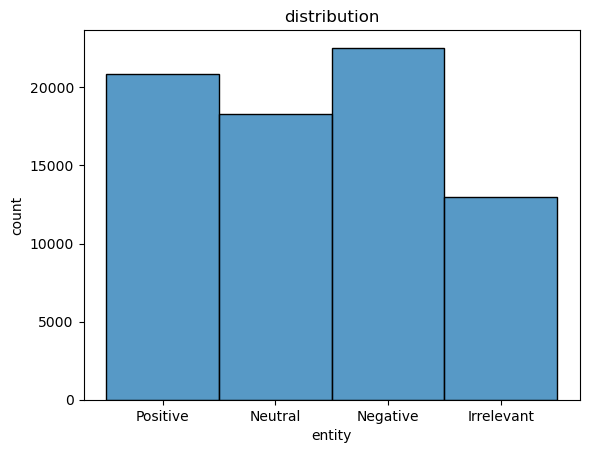

In [ ]:
sns.histplot(data=data_train, x='sentiment', stat="count", multiple="dodge")
plt.xlabel('entity')
plt.ylabel('count')
plt.title('distribution')